In [18]:
# 2-dimensional wave equation
# u_tt = c^2 * (u_xx + u_yy)
# u(0,y,t) = u(a,y,t) = 0   0<=y<=b, t>=0
# u(x,0,t) = u(x,b,t) = 0   0<=x<=a, t>=0
# u(x,y,0) = f(x,y)
# u_t(x,t,0) = g(x,y)
import cmath
import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch
from nangs import *
device = "cuda" if torch.cuda.is_available() else "cpu"

class Wave(PDE):
    def computePDELoss(self, inputs, outputs):
        x, y, t, c=inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3]
        u = outputs[:,0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        u_x, u_y, u_t=grads[:, 0], grads[:, 1], grads[:, 2]
        
        grads2=self.computeGrads(u_x, inputs)
        u_xx=grads2[:, 0]
        
        grads2=self.computeGrads(u_y, inputs)
        u_yy=grads2[:, 1]
        
        grads2=self.computeGrads(u_t, inputs)
        u_tt=grads2[:, 2]
        
        return {'pde': u_tt-c*c*u_xx-c*c*u_yy}
    
pde=Wave(inputs=('x', 'y', 't', 'c'), outputs='u')

In [19]:
# a = b = 1

x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,20)
c = np.array([1e-4,1e-3,1e-2,1e-1,1])

mesh = Mesh({'x': x, 'y': y, 't': t, 'c': c}, device=device)
pde.set_mesh(mesh)

In [20]:
# boundary conditions

x0 = np.array([0., 1.])
y0 = np.array([0., 1.])
t0 = np.array([0])

_x, _y, _t, _c = np.meshgrid(x, y, t0, c)
u0 = np.sin(np.pi*_x)*np.sin(np.pi*_y)
initial_condition=Dirichlet({'x': x, 'y': y, 't': t0, 'c': c}, {'u': u0.reshape(-1)}, 
                            device=device, name='initial')
pde.add_boco(initial_condition)

_x, _y, _t, _c = np.meshgrid(x0, y, t, c)
u1 = _x*_y*_t*_c*0
boco_x=Dirichlet({'x': x0, 'y': y, 't': t, 'c': c}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_x')
pde.add_boco(boco_x)

_x, _y, _t, _c = np.meshgrid(x, y0, t, c)
u1 = _x*_y*_t*_c*0
boco_y=Dirichlet({'x': x, 'y': y0, 't': t, 'c': c}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_y')
pde.add_boco(boco_y)

In [21]:
PI=3.14159265
SQRT_2=1.41421356

class MyNeumann(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        u_t=self.computeGrads(outputs, inputs)[:,2]
        x,y=inputs[:, 0], inputs[:, 1]
        c=inputs[:, 3]
        return {'grad_t': u_t-c*torch.sin(PI*x)*torch.sin(PI*y)*SQRT_2*PI}
    
boco=MyNeumann({'x': x, 'y': y, 't': t0, 'c': c}, name='neumann', device=device)
pde.add_boco(boco)

In [22]:
BATCH_SIZE = 512
LR = 5e-4
EPOCHS = 1000
NUM_LAYERS = 8
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

Wall time: 21h 53min 39s


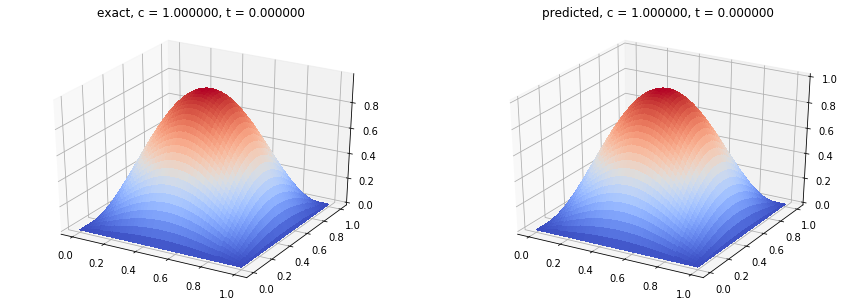

L2 error:  0.04164186599173188


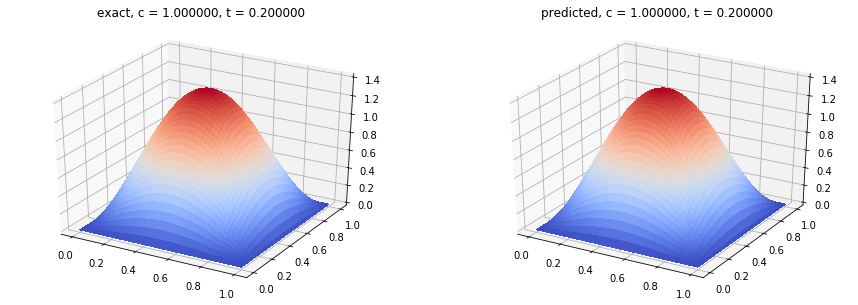

L2 error:  0.04089242578376976


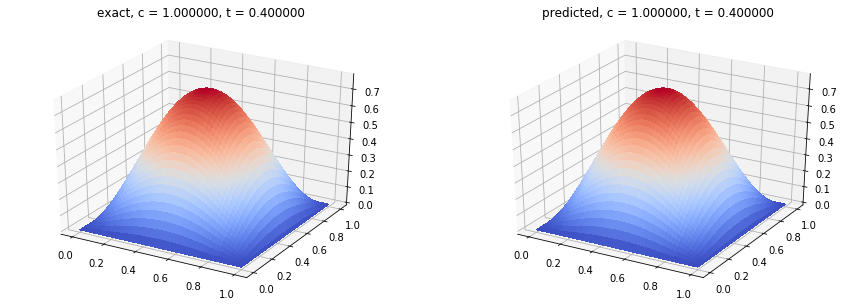

L2 error:  0.03719253719832544


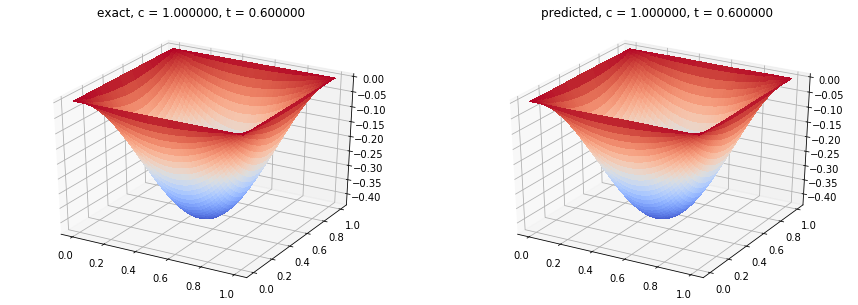

L2 error:  0.0793288001404008


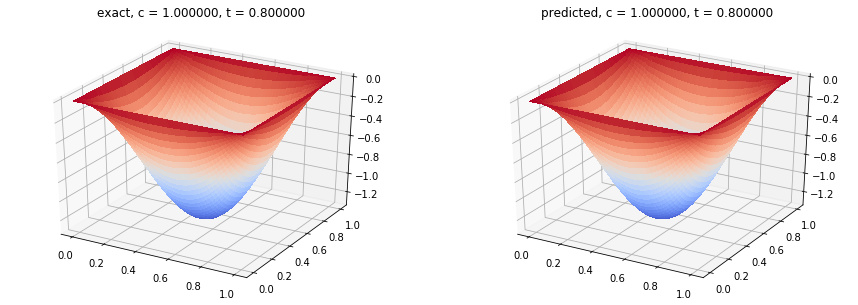

L2 error:  0.09808309281836927


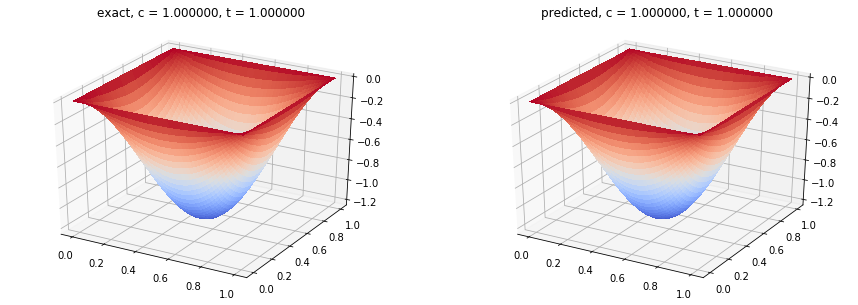

L2 error:  0.1282887409458277


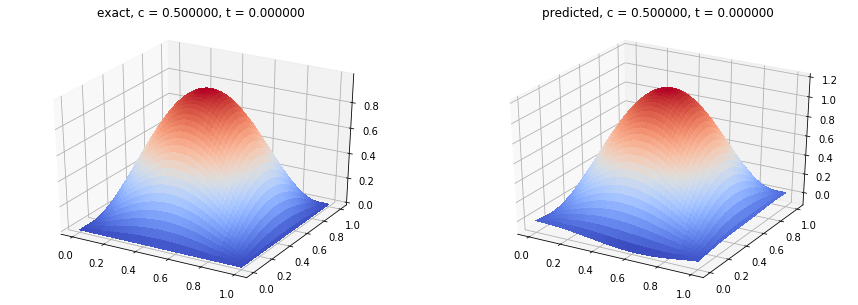

L2 error:  9.854664759287951


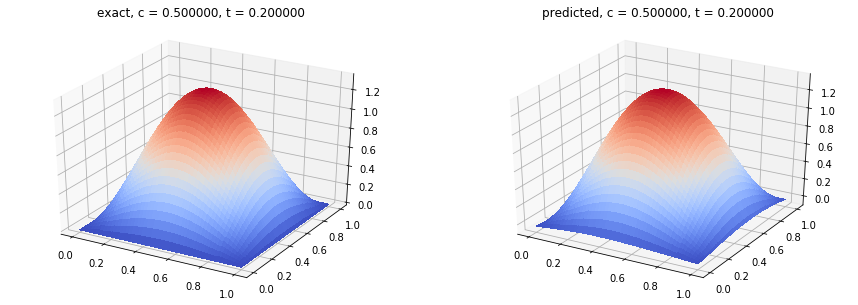

L2 error:  3.238123670352844


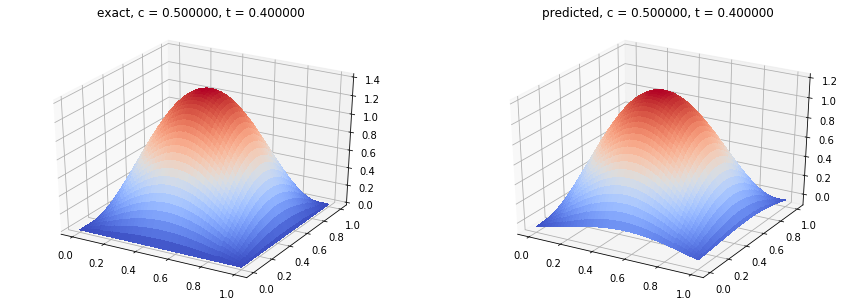

L2 error:  10.373450308769913


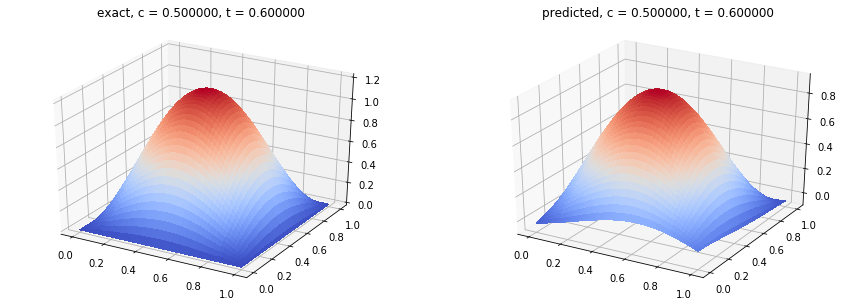

L2 error:  14.165768851508489


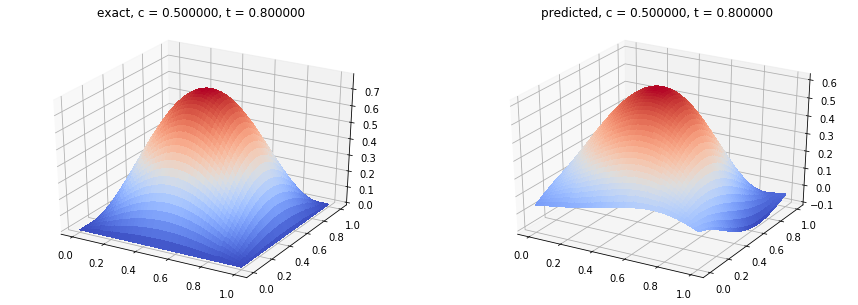

L2 error:  10.139693196709363


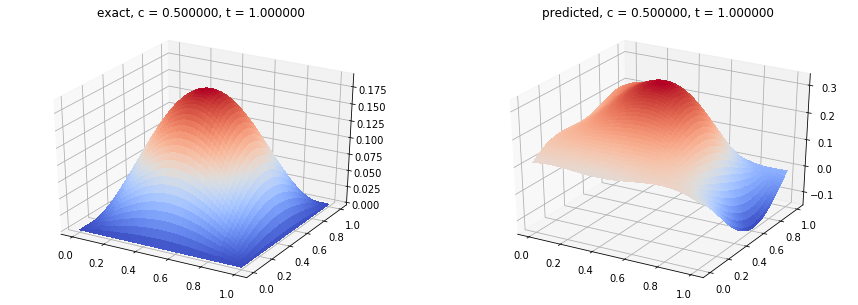

L2 error:  11.805292735420872


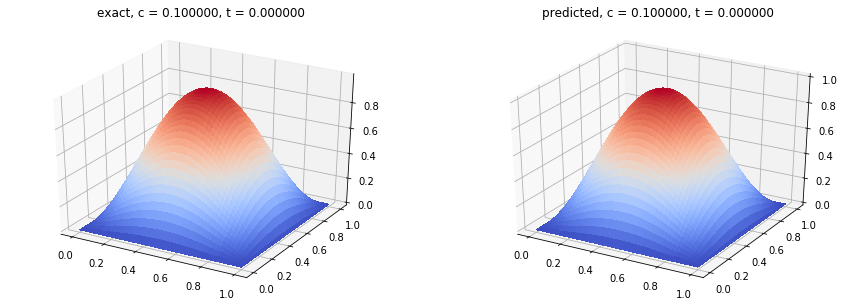

L2 error:  0.05426070531747737


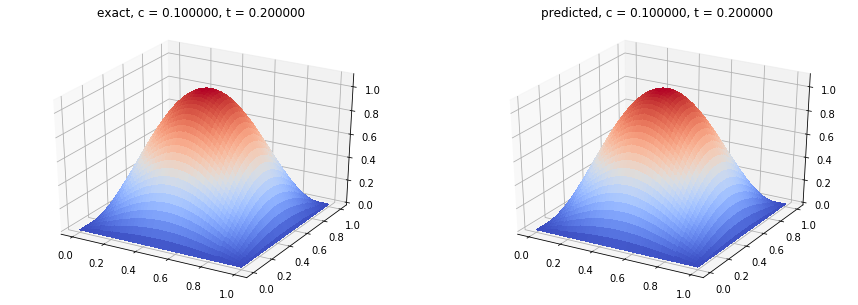

L2 error:  0.051942079678465244


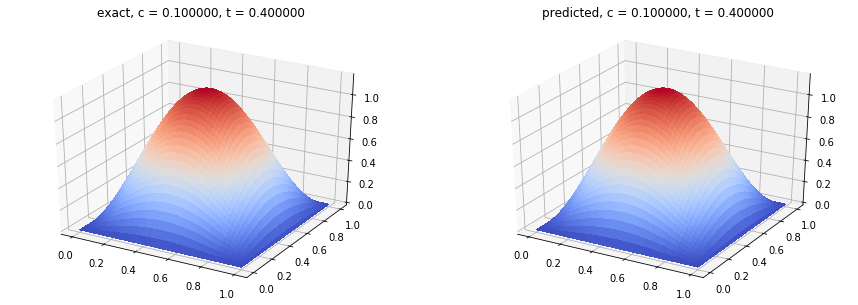

L2 error:  0.05138553180878497


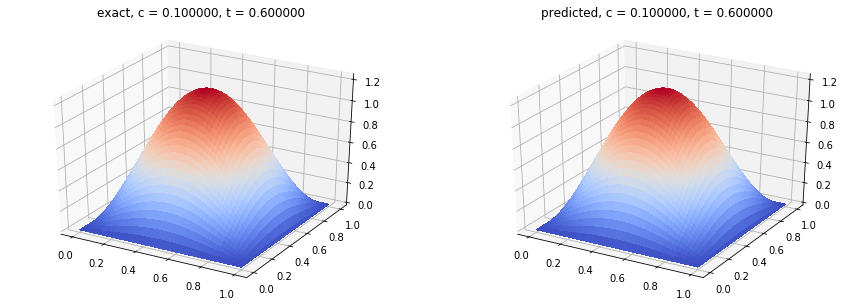

L2 error:  0.054133173492820104


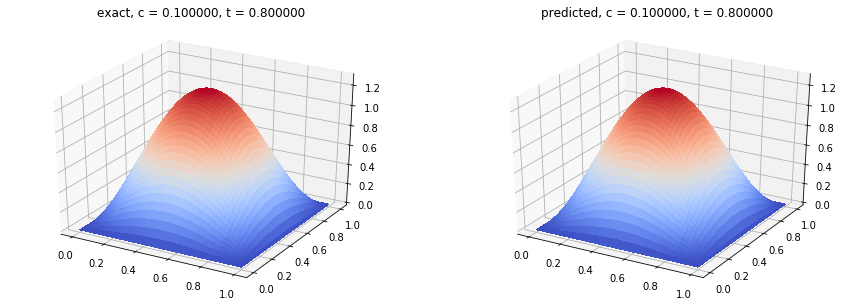

L2 error:  0.062193851435839


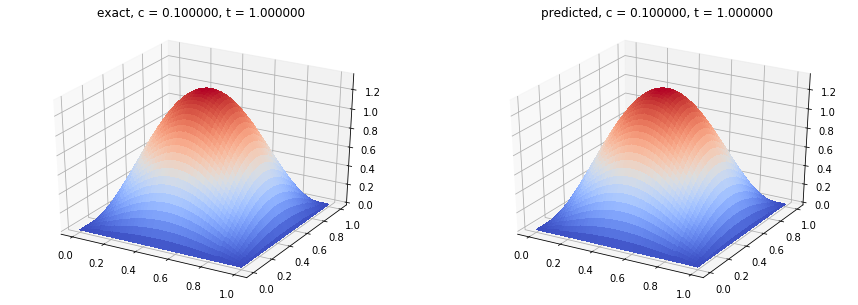

L2 error:  0.07344915039194003


In [27]:
# evaluate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
t = np.array([0,0.2,0.4,0.6,0.8,1])
c = np.array([1e-4,1e-3,1e-2,1e-1,1])
c1 = np.array([1,0.5,0.1])

for cc in c1:
    for t1 in t:

        eval_mesh=Mesh({'x': x, 'y': y, 't': t1, 'c': cc}, device=device)

        u=pde.eval(eval_mesh)
        u=u.cpu().numpy()

        _x, _y=np.meshgrid(x,y)
        u0=np.sin(np.pi*_x)*np.sin(np.pi*_y)*(np.cos(cc*np.sqrt(2)*np.pi*t1)+
                                              np.sin(cc*np.sqrt(2)*np.pi*t1))

        fig=plt.figure(figsize=(15, 5))
        ax1=fig.add_subplot(1,2,1,projection='3d')
        ax2=fig.add_subplot(1,2,2,projection='3d')
        ax1.plot_surface(_x, _y, u0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                         linewidth=0, antialiased=False)
        ax1.title.set_text('exact, c = %f, t = %f' %(cc, t1))
        ax2.plot_surface(_x, _y, u.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                         linewidth=0, antialiased=False)
        ax2.title.set_text('predicted, c = %f, t = %f' %(cc, t1))
        plt.show()
        print("L2 error: ", np.sqrt(sum((u0.ravel()-u.ravel())**2)))

In [ ]:
# version 2

In [33]:
# 2-dimensional wave equation
# u_tt = c^2 * (u_xx + u_yy)
# u(0,y,t) = u(a,y,t) = 0   0<=y<=b, t>=0
# u(x,0,t) = u(x,b,t) = 0   0<=x<=a, t>=0
# u(x,y,0) = f(x,y)
# u_t(x,t,0) = g(x,y)
import cmath
import numpy as np
import matplotlib.pyplot as plt
import nangs
import torch
from nangs import *
device = "cuda" if torch.cuda.is_available() else "cpu"

class Wave(PDE):
    def computePDELoss(self, inputs, outputs):
        x, y, t, c=inputs[:,0], inputs[:,1], inputs[:,2], inputs[:,3]
        u = outputs[:,0]
        
        #compute gradients
        grads=self.computeGrads(outputs, inputs)
        
        #compute loss
        u_x, u_y, u_t=grads[:, 0], grads[:, 1], grads[:, 2]
        
        grads2=self.computeGrads(u_x, inputs)
        u_xx=grads2[:, 0]
        
        grads2=self.computeGrads(u_y, inputs)
        u_yy=grads2[:, 1]
        
        grads2=self.computeGrads(u_t, inputs)
        u_tt=grads2[:, 2]
        
        return {'pde': u_tt-c*c*u_xx-c*c*u_yy}
    
pde=Wave(inputs=('x', 'y', 't', 'c'), outputs='u')

In [34]:
# a = b = 1

x = np.linspace(0,1,20)
y = np.linspace(0,1,20)
t = np.linspace(0,1,20)
c = np.array([0.2, 0.4, 0.6, 0.8, 1])

mesh = Mesh({'x': x, 'y': y, 't': t, 'c': c}, device=device)
pde.set_mesh(mesh)

In [35]:
# boundary conditions

x0 = np.array([0., 1.])
y0 = np.array([0., 1.])
t0 = np.array([0])

_x, _y, _t, _c = np.meshgrid(x, y, t0, c)
u0 = np.sin(np.pi*_x)*np.sin(np.pi*_y)
initial_condition=Dirichlet({'x': x, 'y': y, 't': t0, 'c': c}, {'u': u0.reshape(-1)}, 
                            device=device, name='initial')
pde.add_boco(initial_condition)

_x, _y, _t, _c = np.meshgrid(x0, y, t, c)
u1 = _x*_y*_t*_c*0
boco_x=Dirichlet({'x': x0, 'y': y, 't': t, 'c': c}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_x')
pde.add_boco(boco_x)

_x, _y, _t, _c = np.meshgrid(x, y0, t, c)
u1 = _x*_y*_t*_c*0
boco_y=Dirichlet({'x': x, 'y': y0, 't': t, 'c': c}, {'u': u1.reshape(-1)}, device=device, 
                 name='boco_y')
pde.add_boco(boco_y)

In [36]:
PI=3.14159265
SQRT_2=1.41421356

class MyNeumann(Neumann):
    def computeBocoLoss(self, inputs, outputs):
        u_t=self.computeGrads(outputs, inputs)[:,2]
        x,y=inputs[:, 0], inputs[:, 1]
        c=inputs[:, 3]
        return {'grad_t': u_t-c*torch.sin(PI*x)*torch.sin(PI*y)*SQRT_2*PI}
    
boco=MyNeumann({'x': x, 'y': y, 't': t0, 'c': c}, name='neumann', device=device)
pde.add_boco(boco)

In [37]:
BATCH_SIZE = 512
LR = 5e-4
EPOCHS = 1000
NUM_LAYERS = 8
NUM_HIDDEN = 256

mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, 
                                                pct_start=0.1, total_steps=EPOCHS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(EPOCHS, BATCH_SIZE)

Wall time: 21h 55min 58s


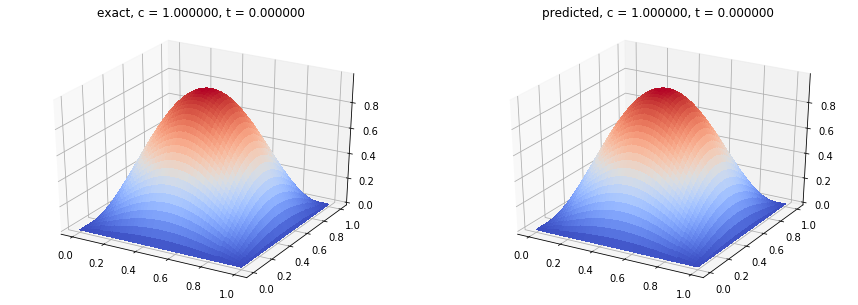

L2 error:  0.06031702657954487


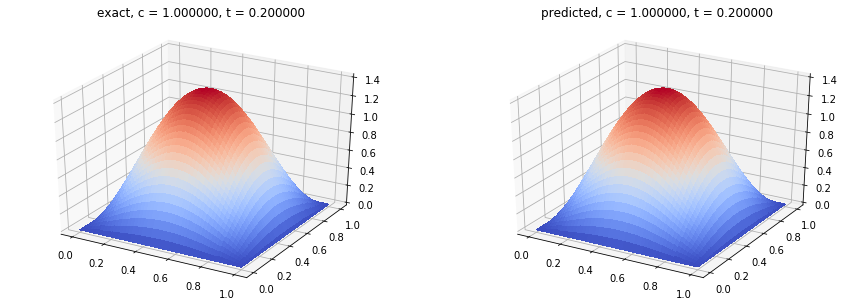

L2 error:  0.04262252142796813


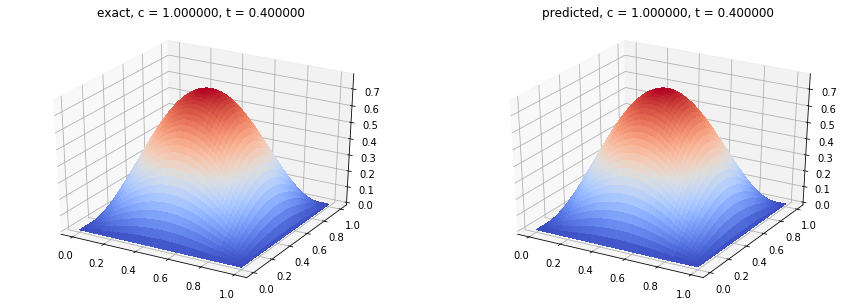

L2 error:  0.08797670390214811


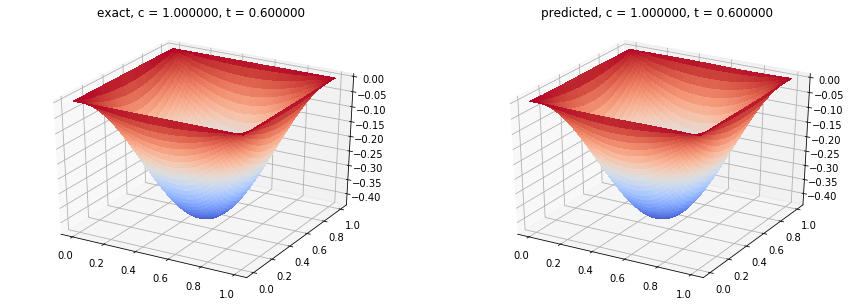

L2 error:  0.0963785262006768


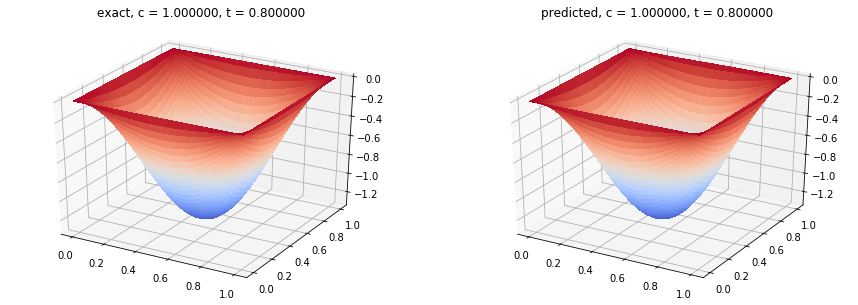

L2 error:  0.11515402846230983


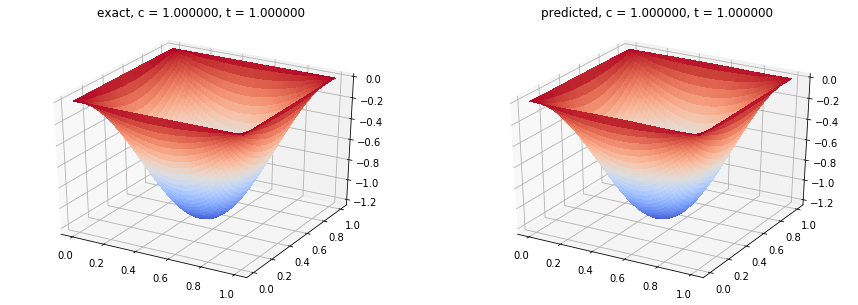

L2 error:  0.2068542243030838


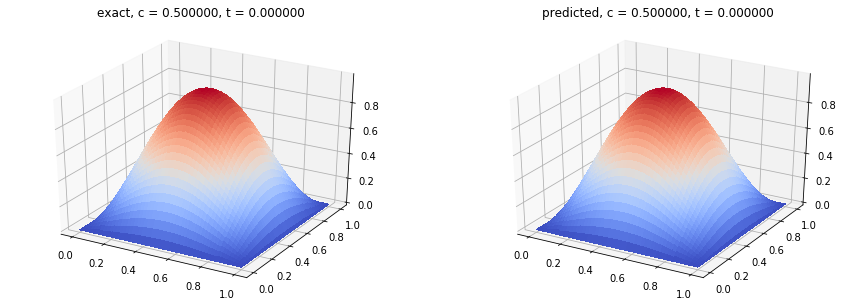

L2 error:  0.104003528677304


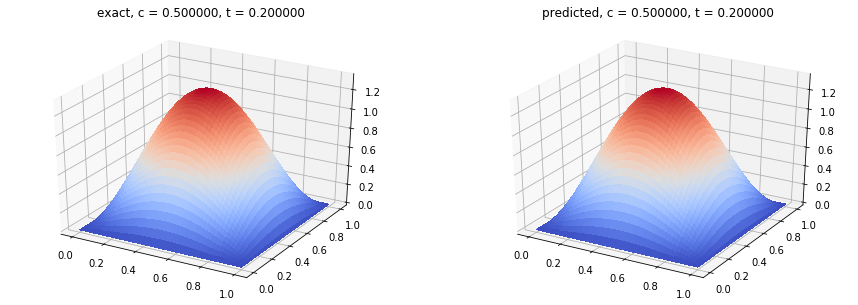

L2 error:  0.05676495134112558


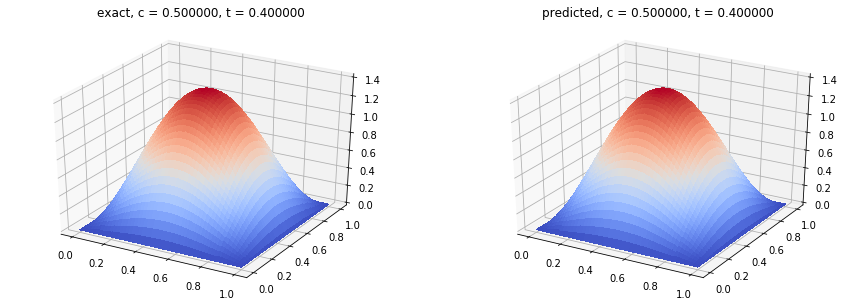

L2 error:  0.05817795364300295


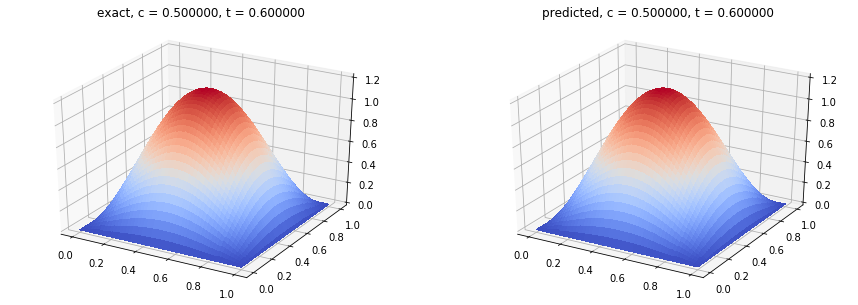

L2 error:  0.05215829922872634


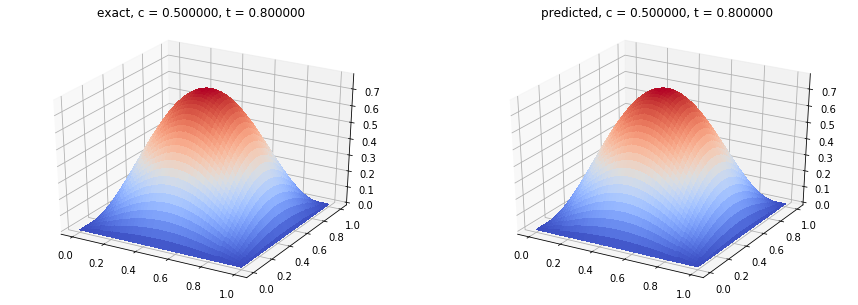

L2 error:  0.058756696168908086


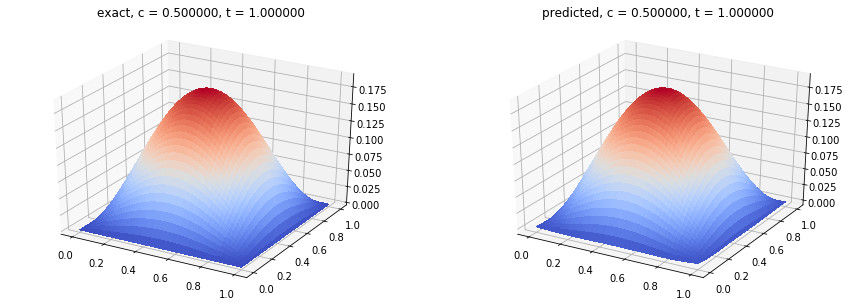

L2 error:  0.10036177056438558


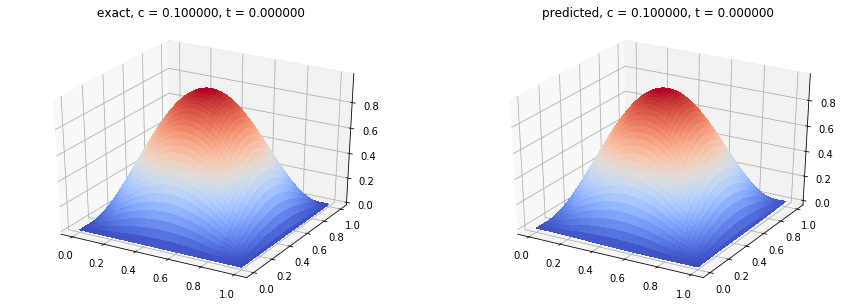

L2 error:  1.3227027905910425


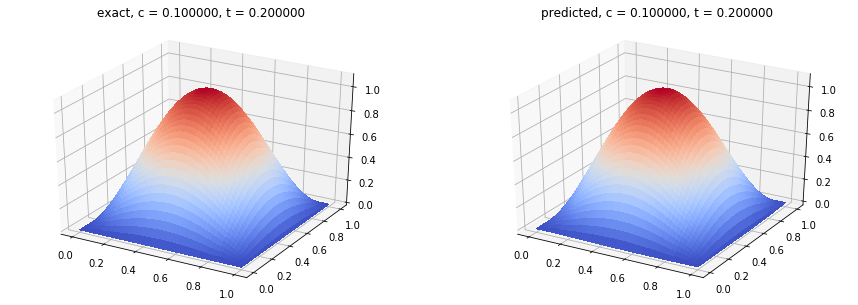

L2 error:  0.6456624620364708


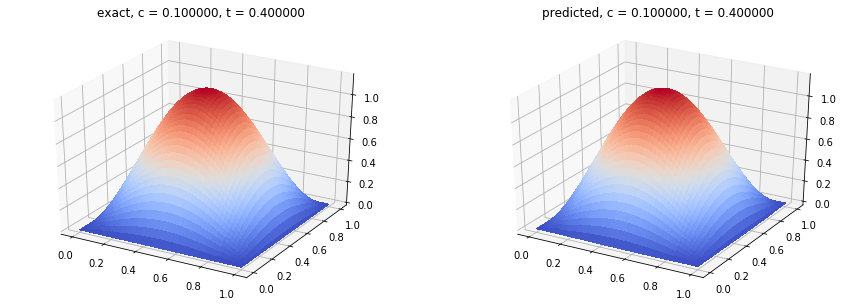

L2 error:  0.7025450300724267


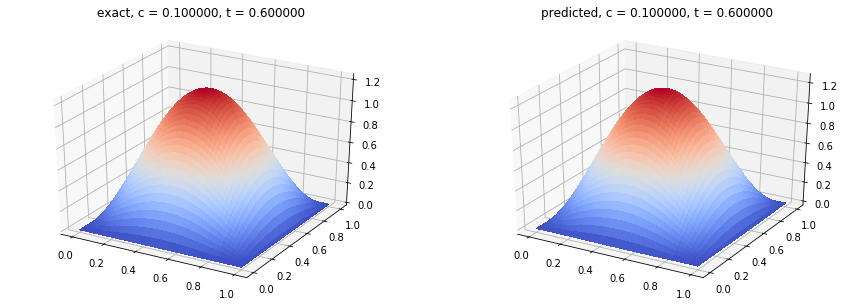

L2 error:  1.382467894409675


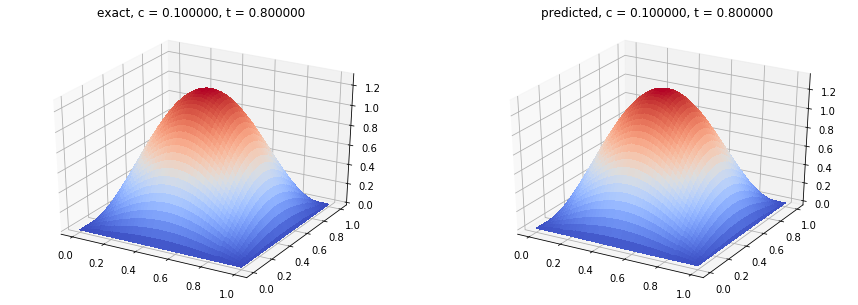

L2 error:  2.1632914500974976


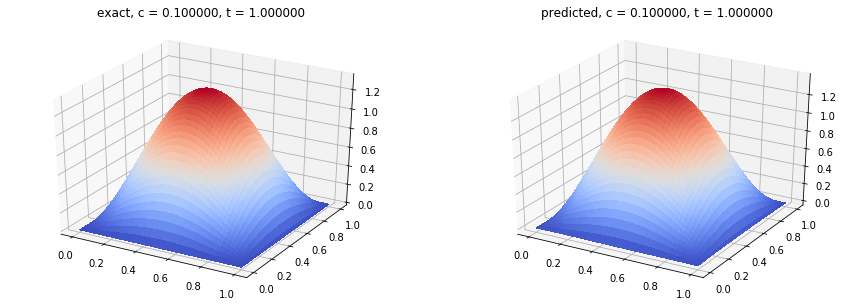

L2 error:  3.0925245464940794


In [38]:
# evaluate
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
t = np.array([0,0.2,0.4,0.6,0.8,1])
c = np.array([1e-4,1e-3,1e-2,1e-1,1])
c1 = np.array([1,0.5,0.1])

for cc in c1:
    for t1 in t:

        eval_mesh=Mesh({'x': x, 'y': y, 't': t1, 'c': cc}, device=device)

        u=pde.eval(eval_mesh)
        u=u.cpu().numpy()

        _x, _y=np.meshgrid(x,y)
        u0=np.sin(np.pi*_x)*np.sin(np.pi*_y)*(np.cos(cc*np.sqrt(2)*np.pi*t1)+
                                              np.sin(cc*np.sqrt(2)*np.pi*t1))

        fig=plt.figure(figsize=(15, 5))
        ax1=fig.add_subplot(1,2,1,projection='3d')
        ax2=fig.add_subplot(1,2,2,projection='3d')
        ax1.plot_surface(_x, _y, u0.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                         linewidth=0, antialiased=False)
        ax1.title.set_text('exact, c = %f, t = %f' %(cc, t1))
        ax2.plot_surface(_x, _y, u.reshape((len(_y),len(_x))), cmap=cm.coolwarm, 
                         linewidth=0, antialiased=False)
        ax2.title.set_text('predicted, c = %f, t = %f' %(cc, t1))
        plt.show()
        print("L2 error: ", np.sqrt(sum((u0.ravel()-u.ravel())**2)))